In [3]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx

import galois

To do:
* need to fix either the Manhattan or the tanner graph function (cluster not symmetric)

 

In [4]:
GF = galois.GF(3)

In [5]:
def tuple_sum(p:Tuple[complex], e:Tuple[complex], Lx, Ly):
    x = (p.real + e.real) % (2*Lx)
    y = (p.imag + e.imag) % (2*Ly)

    return (x+1j*y)

In [6]:
class TC3():
    def __init__(self, Lx, Ly):
        self.Lx, self.Ly = [Lx,Ly]

    def check_data_lists(self):
        qudits_from_plaq: List[Tuple[complex]] = [(1+0*1j), (0+1j)]
        plaq_centers: List[Tuple[complex,complex]] = [((2*i) % (2*self.Lx) + ((2*k) % (2*self.Ly))*1j) for i in range(self.Lx) for k in range(self.Ly)]

        qudits_list: List[Tuple[complex]] = []
        for plaq in plaq_centers:
            qudits_list.append(tuple_sum(plaq, qudits_from_plaq[0], self.Lx, self.Ly))
            qudits_list.append(tuple_sum(plaq, qudits_from_plaq[1], self.Lx, self.Ly))

        plaq_qudit_dictionary = {}
        for count, plaq in enumerate(plaq_centers):
            plaq_qudit_dictionary[count] = [tuple_sum(plaq, qudits_from_plaq[0], self.Lx, self.Ly), tuple_sum(plaq, qudits_from_plaq[1],self.Lx, self.Ly),tuple_sum(plaq, -qudits_from_plaq[0],self.Lx, self.Ly), tuple_sum(plaq, -qudits_from_plaq[1],self.Lx, self.Ly) ]


        self.plaq_pos = plaq_centers
        self.qutrit_pos = qudits_list
        self.plaq_vs_qutrits = plaq_qudit_dictionary

    def parity_check(self):
        H = np.zeros((len(self.plaq_pos),len(self.qutrit_pos)), dtype=int)

        for count_p, p in enumerate(self.plaq_pos):
            for count_q, q in enumerate(self.qutrit_pos):
                if q == self.plaq_vs_qutrits[count_p][0]:
                    H[count_p,count_q] = 1
                elif q == self.plaq_vs_qutrits[count_p][1]:
                    H[count_p,count_q] = 1
                elif q == self.plaq_vs_qutrits[count_p][2]:
                    H[count_p,count_q] = 2
                elif q == self.plaq_vs_qutrits[count_p][3]:
                    H[count_p,count_q] = 2
        
        self.H = GF(H)

    def tanner_graph(self):
        "Create tanner graph from a parity check matrix H."
        m, n = self.H.shape
        T = nx.Graph()

        T.H = self.H
        # nodes
        T.VD = [i for i in range(n)]
        T.Dpos = [self.qutrit_pos[i] for i in range(n)]
        T.VC = [-j-1 for j in range(m)]
        T.Cpos = [self.plaq_pos[j] for j in range(m)]

        # add them, with positions
        #for i, node in enumerate(T.VD):
            #T.add_node(node, pos=((i-n/2), 0), label='$d_{'+str(i)+'}$')
        #for j, node in enumerate(T.VC):
            #T.add_node(node, pos=((j-m/2), 1), label='$c_{'+str(j)+'}$')

             #add them, with positions
        for i, node in enumerate(T.VD):
            T.add_node(node, pos=(T.Dpos[i].real, T.Dpos[i].imag), label='$d_{'+str(i)+'}$')
        for j, node in enumerate(T.VC):
            T.add_node(node, pos=(T.Cpos[j].real, T.Cpos[j].imag), label='$c_{'+str(j)+'}$')

        # add checks to graph
        for j, check in enumerate(T.H):
            for i, v in enumerate(check):
                if v==1:
                    T.add_edge(-j-1, i, label = 'Z')
                elif v==2:
                    T.add_edge(-j-1, i, label = 'Zt')

        self.T = T

    def logicals(self):
        qudits = self.T.VD
        Z_vertical, Z_horizontal = [np.zeros(len(qudits), dtype=int), np.zeros(len(qudits), dtype = int)]
        Z_vlist, Z_hlist = [set(), set()]

        for y in range(self.Ly):
            Z_vertical[1+2*y] = 1
            Z_vlist.add(1+2*y)

        for x in range(self.Lx):
            Z_horizontal[2+2*self.Ly*x] = 1
            Z_hlist.add(2+2*self.Ly*x)


        self.Z1, self.Z1list = [Z_vertical, Z_vlist]
        self.Z2, self.Z2list = [Z_horizontal, Z_hlist]

    
        


In [7]:
def draw_tanner_graph(T, highlight_vertices=None):
    "Draw the graph. highlight_vertices is a list of vertices to be colored."
    plt.figure(figsize=(20,15))
    
    pl=nx.get_node_attributes(T,'pos')
    lbls_nodes = nx.get_node_attributes(T, 'label')
    lbls_edges = nx.get_edge_attributes(T, 'label')

    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VD, node_shape='o')
    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VC, node_shape='s')
    nx.draw_networkx_labels(T, pos=pl, labels=lbls_nodes)

    #for i, edge in enumerate(T.edges):
        #nx.draw_networkx_edges(T, pos=pl, edgelist=T.edges[edge])
    
    nx.draw_networkx_edges(T, pos=pl, label= lbls_edges)

    if highlight_vertices:
        nx.draw_networkx_nodes(T,
                               pos=pl,
                               nodelist=[int(v[1:]) for v in highlight_vertices if v[0] == 'd'],
                               node_color='red',
                               node_shape='o')
        nx.draw_networkx_nodes(T,
                       pos=pl,
                       nodelist=[-int(v[1:])-1 for v in highlight_vertices if v[0] == 'c'],
                       node_color='red',
                       node_shape='s')

    
    plt.axis('off');


# these four functions allow us to convert between 
# (s)tring names of vertices and (i)nteger names of vertices
def s2i(node):
    return int(node[1:]) if node[0] == 'd' else -int(node[1])-1

def i2s(node):
    return f'd{node}' if node>=0 else f'c{-node-1}'

def ms2i(W: set):
    return set(map(s2i, W))

def mi2s(W: set):
    return set(map(i2s, W))

def i2pos(T,node):
    return T.Dpos[node] if node>=0 else T.Cpos[-node-1]

## Parity check matrix

# Generate Error:

In [8]:
def Error(p, H):
    data_qutrit = np.zeros(H.shape[1], dtype=int)
    for q in range(H.shape[1]):
        p0 = np.random.random(1)
        if p0<p:
            data_qutrit[q] = 1
        elif p<p0<2*p:
            data_qutrit[q] = 2

    return GF(data_qutrit)

def syndrome(E, code):
    return code.T.H @ E
    

def Bad_syndromes(E, code):
    S = syndrome(E, code)
    S_list = [] # want this in terms of node convention above where check nodes labelled by n<0
    for i in range(len(S)):
        if S[i]!=0:
            S_list.append(-i-1)
    
    return S_list

    
    

# Clustering algorithm

In [9]:
# want to write everything in terms of node labels

def Manhattan(nodeC, nodeD, code): #S and T have format [(x+iy, t), syndrome]
    Lx, Ly = [code.Lx, code.Ly]
    pC, pD = [i2pos(code.T, nodeC), i2pos(code.T,nodeD)]
    
    lattice_correction = 0
    if nodeC>-1 and nodeD>-1 and nodeC!=nodeD:
        if nodeC%2==0 and nodeD%2 ==0 and np.real(pC) == np.real(pD):
            lattice_correction +=2
        if nodeC%2==1 and nodeD%2 ==1 and np.imag(pC) == np.imag(pD):
            lattice_correction +=2

    x = min(np.real(pC - pD)%(2*Lx), np.real(-pC + pD)%(2*Lx))
    y = min(np.imag(pC - pD)%(2*Ly), np.imag(-pC + pD)%(2*Ly))
    
    
    
    return x+ y + lattice_correction


def plaquette_nhoods(Error, delta, code, string = False):
    Sbad = Bad_syndromes(Error, code)

    data_nodes = code.T.VD
    check_nodes = code.T.VC
    nodes = list(set(data_nodes).union(set(check_nodes)))
    cluster_list = []

    if string == False:
        for p_bad in Sbad:
            cluster_p = [set([p_bad]), set([])]
            for i,node in enumerate(nodes):
                if Manhattan(p_bad, node, code) < delta:
                    cluster_p[1].add(node)
            cluster_list.append(cluster_p)

    elif string == True:
        for p_bad in Sbad:
            cluster_p = [set([i2s(p_bad)]), set()]
            for i,node in enumerate(nodes):
                if Manhattan(p_bad, node, code) < delta:
                    cluster_p[1].add(i2s(node))
            cluster_list.append(cluster_p)

    return cluster_list
    
# returns a list of clusters [{S1,S2,S3,...}, {nodesD,nodesC}]
# add function to trim interior
def merge_clusters(Error, delta, code):
    balls_list = plaquette_nhoods(Error, delta, code, string = False)
    
    n=0
    cluster_list = []
    test_ticker = 0
    if len(balls_list) == 0:   
        n+=1
    
    else:
        while(len(balls_list))>0:
            to_delete = [0]
            temp_cluster = balls_list[0] #ball_list[0] = [{plaq}, {qutrits}] 
            for b, ball in enumerate(balls_list[1:]):
                
                if ball[1].isdisjoint(temp_cluster[1]) == False:
                    temp_cluster[0] = temp_cluster[0].union(ball[0])
                    temp_cluster[1] = temp_cluster[1].union(ball[1])

                    to_delete.append(b+1)
                    
            for i in reversed(to_delete):
                balls_list.pop(i)
                
            cluster_list.append(temp_cluster)

    return cluster_list

def trim_cluster():

    return
    
    

## Decoding a cluster:
Suppose we have cluster associated with violated syndromes $S$ and nearby data qubits $e$. These define a submatrix $A$ of the parity check matrix H

Decoding, by guessing an error $\tilde{e}$, amounts to solving the equation: $A \tilde{e} = \sigma(e)_{int(K)}$


$$ He = S \implies \begin{pmatrix}
h_{11} & h_{12} & h_{13} & \dots & S_1\\
h_{21} & h_{22} & h_{23} & \dots & S_2\\
& & \vdots & \\
h_{n1} & h_{n2} & h_{n3} & \dots & S_n\\
 
\end{pmatrix} 
\begin{pmatrix}
e_1 \\ e_2 \\ \vdots \\ e_m \\ -1
\end{pmatrix}

= 0
 

## Start from here: Need to fix this so everything is in terms of Errors

In [10]:
def solvable(H, S):

    H_rank = np.linalg.matrix_rank(H)
    HS = np.hstack((H, np.atleast_2d(S).T))
    
    return H_rank == np.linalg.matrix_rank(HS) 

def solve_cluster(H,S):
    #find random solution to He = S
    n_data = H.shape[1]
    H_rank = np.linalg.matrix_rank(H)

    HS = np.hstack((H, np.atleast_2d(S).T))
    if solvable(H,S) == False:
        raise Exception('something wrong, no solution')
    
    HSrr = HS.row_reduce()

    #swaps 
    swaps = []
    for i in range(min(HSrr.shape)):
        if HSrr[i,i] == 0:
            for j in range(i+1,n_data):
                if HSrr[i,j] != 0:
                    HSrr[:, [i,j]] = HSrr[:, [j,i]]
                    swaps.append((i,j))
                    break

    n_ind = n_data-H_rank
    ind_vars = GF(np.zeros(n_ind,dtype = int))

    dep_vars = -HSrr[:H_rank, H_rank:n_data] @ ind_vars + HSrr[:H_rank, -1]

    e = np.hstack((dep_vars, ind_vars))

    for s in reversed(swaps):
        e[s[0]], e[s[1]] = e[s[1]], e[s[0]]


    return GF(e)

Now that we've worked out how to find errors we need to define a function which:
1. Decodes an a given cluster and embeds the solution in the entire space of data qubits
2. does the above for all the clusters, returns the net error and uses this to update the syndrome
3. 

In [11]:
def Decoded(H, E):
    clean_syndrome = GF(np.zeros(H.shape[0], dtype=int))

    return (H @ E == clean_syndrome).all()

In [12]:
def decode_cluster(Syndrome, cluster, code):
    cluster_nodes = cluster[1]
    
    check_nodes = sorted([-node-1 for node in cluster_nodes if node<0])
    data_nodes = sorted([node for node in cluster_nodes if node>=0]) 

    H_sub = code.H[check_nodes][:,data_nodes]
    S_sub = Syndrome[check_nodes]

    full_error = GF(np.zeros(2*code.Lx*code.Ly, dtype=int)) #need to embedd the solution in an array for all the data qubits
    
    if solvable(H_sub, S_sub):
        solution = solve_cluster(H_sub, S_sub) #this will return an correction vector lying in the cluster
        
        for i, node in enumerate(data_nodes):
            full_error[node] = solution[i]


    return GF(full_error)

def decode_cluster_layer(Syndrome, clusters,code):
    n_clusters = len(clusters)

    correction = GF(np.zeros(2*code.Lx*code.Ly,dtype=int))
    
    for i, cluster in enumerate(clusters):
        correction += decode_cluster(Syndrome, cluster, code)

    return correction



def cluster_decoder(Error, code):
    E = Error
    S = syndrome(E,code)
    S_index = Bad_syndromes(E,code)

    #print(S)
    #E_correction = GF(np.zeros(2*code.Lx*code.Ly,dtype=int))
    delta = 2.1

    while not Decoded(code.H, E): 
     # change this
        cluster_list = merge_clusters(E, delta, code)

        E_correction = decode_cluster_layer(S, cluster_list, code)
        E-=E_correction

        S = syndrome(E,code)
        S_index = Bad_syndromes(E,code)
        #print(f"did layer {delta}")

        delta +=2
        if delta>max(2*code.Lx+2, 2*code.Ly+2):
            break

    return E       #returns E_inital-E_correction

In [11]:
C1 = TC3(10,10)
C1.check_data_lists()
C1.parity_check()
C1.tanner_graph()
C1.logicals()

In [12]:
import time

t0 = time.time()

fails = 0
for i in range(1000):
    e = Error(.1,C1.T.H)
    S = syndrome(e, C1)
    e_corr = cluster_decoder(e, C1)

    if not ((C1.H @ e_corr) == GF(np.zeros(C1.H.shape[0], dtype=int))).all():
        fails +=1
        print(C1.H @ e_corr)

print(f'fails: {fails}')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 0 0 1 0 0 0 1 0 0 1 2 0 0 1 0 2 2 1 0 2 1 0 2 0 2 1 2 0 2 0 0 1 1 0 1 2
 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 2 1 2 1 1 0 1 2 1 1 1 2 1 0 0 0 0 2 1 2
 2 0 0 0 2 2 0 2 1 0 1 1 1 0 0 0 1 2 0 0 2 1 0 1 0 2]
[2 1 0 0 0 0 2 0 0 0 2 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 2 1 1 1 0 0 0 0 0 1 1
 1 2 2 1 0 0 0 0 0 2 0 0 0 1 2 0 0 0 2 2 2 1 2 1 2 2 0 1 1 1 0 0 0 2 1 2 2
 0 2 1 2 0 0 0 0 0 0 2 0 0 1 0 0 0 0 2 0 1 0 2 2 1 1]
[0 2 2 0 2 1 2 2 0 0 1 1 2 2 2 1 0 2 0 0 2 0 1 0 1 0 0 0 2 0 2 0 0 2 0 0 2
 0 1 0 0 1 1 0 0 0 2 2 2 0 0 1 1 2 0 0 2 1 2 0 0 2 2 1 2 1 2 2 2 0 0 0 0 0
 0 0 2 1 0 1 1 0 0 1 0 0 1 2 0 0 0

In [20]:
fails = 0
for i in range(1000):
    e = Error(.1,C1.T.H)
    S = syndrome(e, C1)
    cluster = merge_clusters(e, max(C1.Lx, C1.Ly), C1)

    if len(cluster)>0:
        e_cluster = decode_cluster(S,cluster[0],C1)


        cluster_nodes = cluster[0][1]
        
        check_nodes = sorted([-node-1 for node in cluster_nodes if node<0])
        data_nodes = sorted([node for node in cluster_nodes if node>=0]) 
        H_sub = C1.H[check_nodes][:,data_nodes]
        



        if not (H_sub@(e_cluster[data_nodes]-e[data_nodes]) == GF(np.zeros(H_sub.shape[0], dtype=int))).all():
            fails +=1
            print(H_sub@(e_cluster[data_nodes]-e[data_nodes]))

print(f'fails: {fails}')

fails: 0


In [83]:
S

GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0], order=3)

In [21]:
threshhold_dict = {}
N_list = [6,12]
for L in N_list:
    threshhold_dict[L] = []


In [22]:
p_list = [.001, .005, .01, .015]

In [28]:
import time
t0 = time.time()

runs = {}
runs[6] = 2*10**4
runs[12] = 5*10**3

for L in N_list:

    codeL = TC3(L,L)
    codeL.check_data_lists()
    codeL.parity_check()
    codeL.tanner_graph()
    codeL.logicals()

    for i,p in enumerate(p_list):
        success, decoded_fail = [0, 0]
        for n in np.arange(runs[L]):
            e = Error(p,codeL.T.H)
            e_corr = cluster_decoder(e,codeL)

            if not ((codeL.H @ e_corr) == GF(np.zeros(codeL.H.shape[0], dtype=int))).all():
                decoded_fail +=1
                print(f'decode fail number {decoded_fail}')

            if (e_corr )@ GF(codeL.Z1) ==0 and (e_corr)@ GF(codeL.Z2) ==0:
                success+=1

            if n %int(runs[L]/10)==0:
                print(f'finished run {n} w/ prob {p} for L ={L} at time {(time.time()-t0)/60} mins with threshold {success/(n+1)}')
        
        threshhold_dict[L].append(success/(runs[L]+1))
        print(f'finished L ={L} at time {time.time()-t0} with failure threshold {success/(runs[L])}')

finished run 0 w/ prob 0.001 for L =12 at time 0.008180348078409831 mins with threshold 1.0
finished run 500 w/ prob 0.001 for L =12 at time 0.055086096127827965 mins with threshold 0.998003992015968
finished run 1000 w/ prob 0.001 for L =12 at time 0.09947253068288167 mins with threshold 0.997002997002997
finished run 1500 w/ prob 0.001 for L =12 at time 0.14214757680892945 mins with threshold 0.9980013324450366
finished run 2000 w/ prob 0.001 for L =12 at time 0.1847442110379537 mins with threshold 0.9985007496251874
finished run 2500 w/ prob 0.001 for L =12 at time 0.23200997908910115 mins with threshold 0.9976009596161536
finished run 3000 w/ prob 0.001 for L =12 at time 0.277701465288798 mins with threshold 0.9980006664445185
finished run 3500 w/ prob 0.001 for L =12 at time 0.3210104465484619 mins with threshold 0.9980005712653528
finished run 4000 w/ prob 0.001 for L =12 at time 0.36601136525472006 mins with threshold 0.9977505623594102
finished run 4500 w/ prob 0.001 for L =12 

In [37]:
threshhold_dict[6]

[0.9992500374981251,
 0.9799510024498775,
 0.9227038648067597,
 0.8508074596270186]

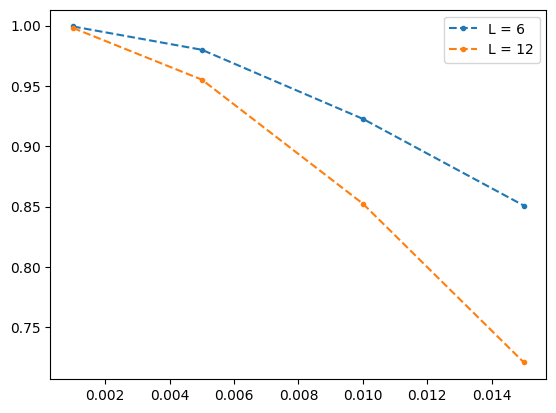

In [38]:
plt.plot(p_list[:], threshhold_dict[6][:], '.--', label = f'L = {6}')
plt.plot(p_list[:], threshhold_dict[12][:], '.--', label = f'L = {12}')
plt.legend()

In [ ]:
syndrome(GF(codeL.Z2),codeL)

GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], order=3)

In [ ]:
codeL.Lx

15

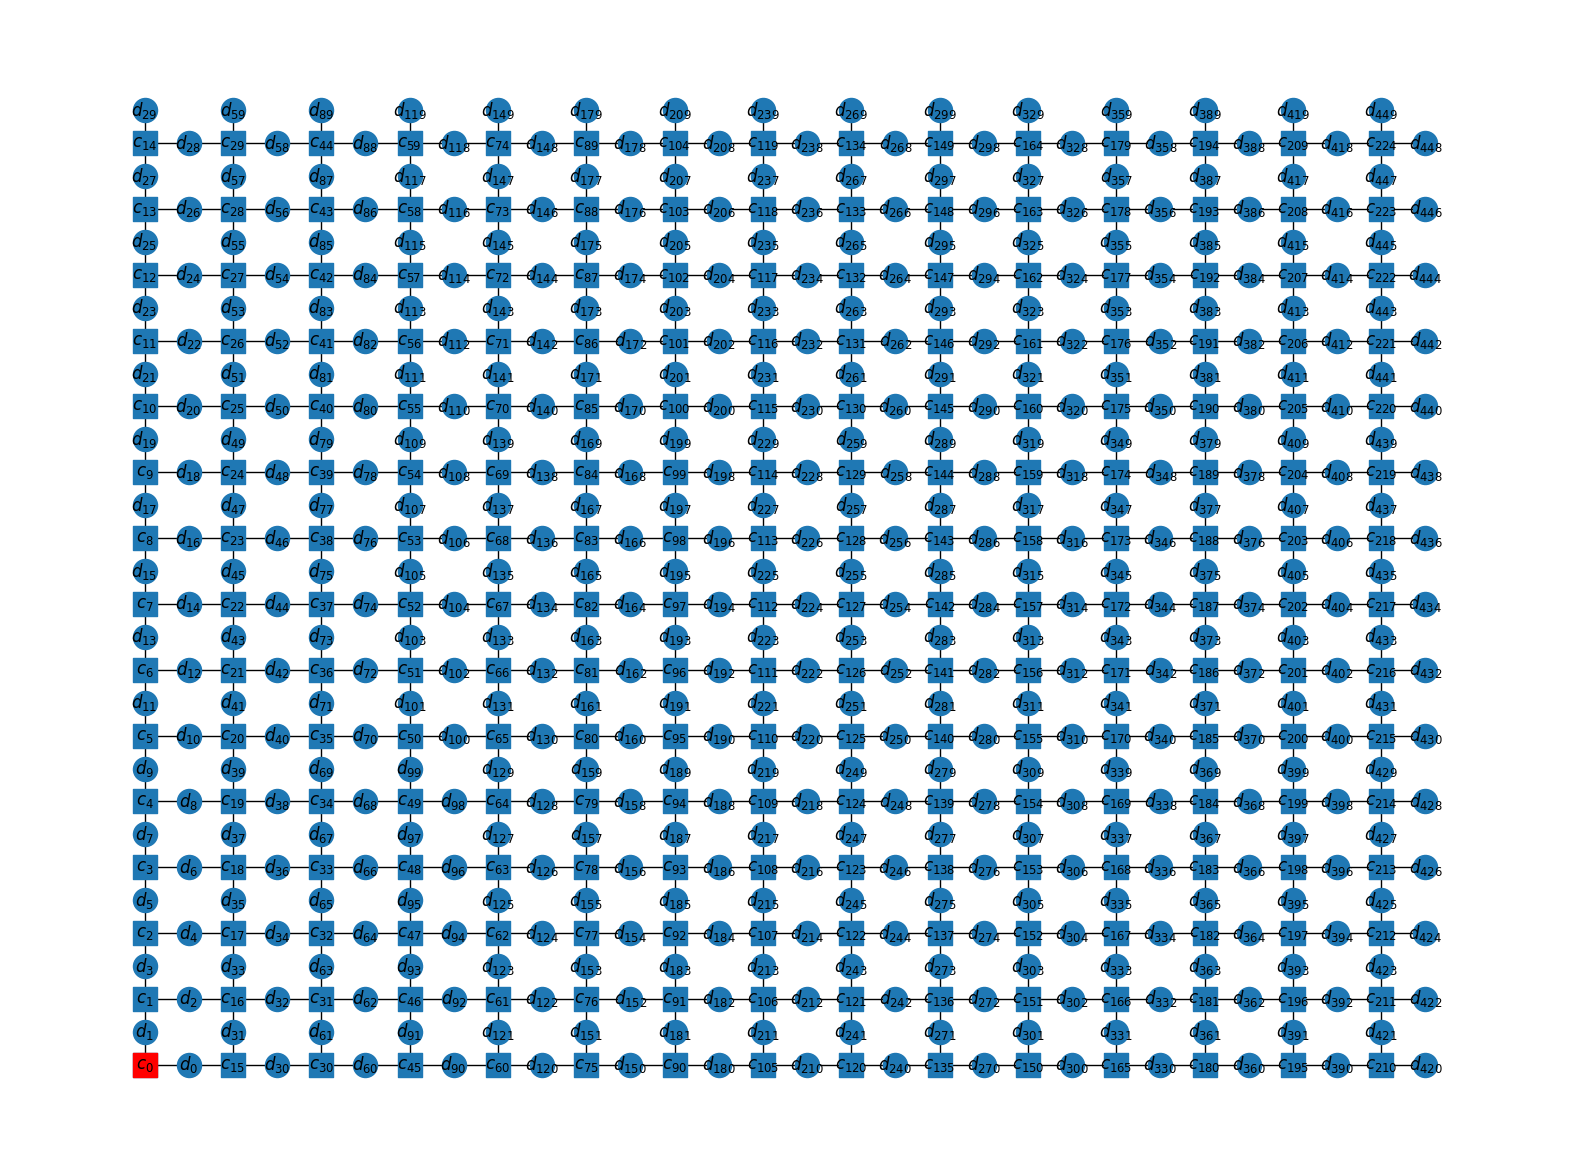

In [ ]:
draw_tanner_graph(codeL.T, mi2s({-1}))

In [ ]:
codeL.plaq_vs_qutrits[0]

[(1+0j), 1j, (39+0j), 39j]

In [ ]:
i2pos(codeL.T,29)

29j